In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim import Optimizer

In [4]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [5]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
wandb.init(
    project='conv-network-mnist',
    config={}
)

wandb: Currently logged in as: maksim1nikolin (nikolin_team). Use `wandb login --relogin` to force relogin


**Data**

In [77]:
# Скачиваем датасет, дальше смотрим как он выглядит внутри
train = torchvision.datasets.MNIST('./mnist/', train=True, download=True, transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('./mnist/', train=False, download=True, transform=torchvision.transforms.ToTensor())

In [78]:
# Разбиваем трэйновый датасет: 80% - трэйновый, 20% - валидационный
train_size = int(0.8 * len(train))
val_size = len(train) - train_size
train, val = torch.utils.data.random_split(train, [train_size, val_size])

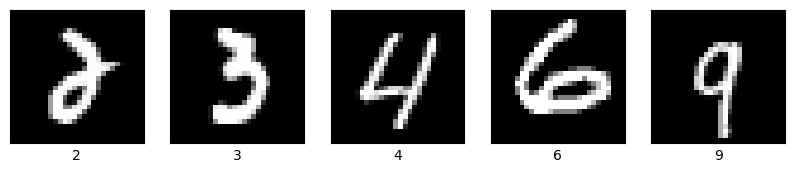

In [79]:
# Смотрим, что внутри датасета и визуализируем
cols, rows = 5, 1
fig = plt.figure(figsize=(2*cols, 2*rows))
for i in range(cols):
  for j in range(rows):
    random_index = np.random.randint(0, len(train))
    ax = fig.add_subplot(rows, cols, i * rows + j + 1)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(train[random_index][0].squeeze(0).numpy().reshape([28, 28]), cmap='gray')
    ax.set_xlabel(train[random_index][1])
plt.show()

In [80]:
train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=64)
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1024)
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=10000)

**Models**

In [102]:
class LarisaNet(nn.Module):
  def __init__(self, in_features, hide_neurons, out_size):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(in_features, hide_neurons),
        nn.ReLU(),
        nn.Linear(hide_neurons, hide_neurons // 2),
        nn.ReLU(),
        nn.Linear(hide_neurons // 2, hide_neurons // 4),
        nn.ReLU(),
        nn.Linear(hide_neurons // 4, out_size),
        nn.Softmax()
    )

  def forward(self, X):
    H = torch.flatten(X, start_dim=1)
    return self.model(H)

In [82]:
# сверточная

In [83]:
# сверточная побольше

In [84]:
# с дропаутами и чем-то еще

**Train**

In [85]:
# Задаем device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [110]:
# Функция трэйна для одной эпохи
def train_epoch(train_loader, optimizer, model, criterion, device=device):

  train_loss, train_accuracy = 0.0, 0.0

  for images, labels in tqdm(train_loader, desc='Training'):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logits = model(images)      # logits: [batch_size x num_classes]
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item() * images.shape[0]
    train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

  return train_loss, train_accuracy

# Функция тест для одной эпохи
def test_epoch(test_loader, model, criterion, device=device):

  val_loss, val_accuracy = 0.0, 0.0

  for images, labels in tqdm(test_loader, desc='Validating'):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      logits = model(images)
      loss = criterion(logits, labels)

    val_loss += loss.item() * images.shape[0]
    val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

  return val_loss, val_accuracy

In [119]:
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
  clear_output()
  fig, axs = plt.subplots(1, 2, figsize=(8, 3))
  axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
  axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
  axs[0].set_ylabel('loss')

  axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
  axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
  axs[1].set_ylabel('accuracy')

  for ax in axs:
    ax.set_xlabel('epoch')
    ax.legend()

  plt.show()

In [113]:
# Функция для всего обучения модели
def train(model, optimizer, criterion, scheduler, train_loader, val_loader, device=device):

  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []

  for epoch in range(1, NUM_EPOCH + 1):

    print('Epoch', epoch)
    model.train()
    train_loss, train_accuracy = train_epoch(train_loader, optimizer, model, criterion, device)

    if scheduler is not None:
      scheduler.step()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_loss)

    model.eval()
    val_loss, val_accuracy = test_epoch(val_loader, model, criterion, device)

    val_loss /= len(train_loader.dataset)
    val_accuracy /= len(train_loader.dataset)
    val_losses.append(train_loss)
    val_accuracies.append(train_loss)

    plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

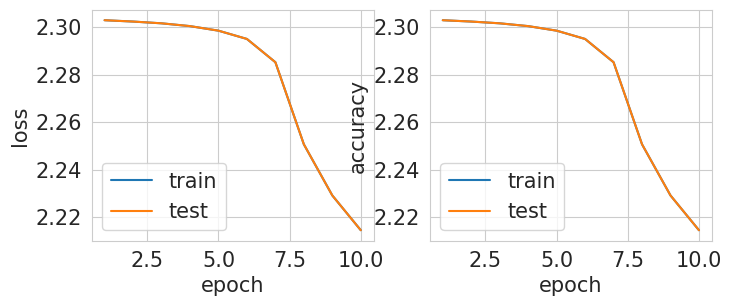

In [120]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCH = 10
LR = 0.01

wandb.config['dataset'] = 'MNIST'
wandb.config['architecture'] = 'FCNN'
wandb.config['scheduler'] = 'None'
wandb.config['epochs'] = NUM_EPOCH
wandb.config['learning_rate'] = LR

model = LarisaNet(IMG_SIZE ** 2, HIDDEN_SIZE, NUM_CLASSES).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0)
criterion = nn.CrossEntropyLoss()
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH)

train(model, optimizer, criterion, None, train_loader, val_loader, device=device)

In [ ]:
import random

epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
  acc = 1 - 2 ** -epoch - random.random() / epoch - offset
  loss = 2 ** -epoch + random.random() / epoch + offset

  wandb.log({"acc": acc, "loss": loss})

wandb.finish()